In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from koinapy import Koina
from sklearn.metrics import ConfusionMatrixDisplay
from pyteomics.electrochem import charge
import numpy as np

In [2]:
fp_seen = r"C:\Users\student\Desktop\Detectability\observedPeptides.tsv"
fp_unseen = r"C:\Users\student\Desktop\Detectability\peptidesNotSeen.tsv"
fp_poorly_detected = r"C:\Users\student\Desktop\Detectability\poorlyObservedRegions.tsv"

df_seen = pd.read_csv(fp_seen, sep="\t").drop_duplicates()
df_unseen = pd.read_csv(fp_unseen, sep="\t").drop_duplicates()
df_poorly_detected = pd.read_csv(fp_poorly_detected, sep="\t").drop_duplicates()

df_seen.shape, df_unseen.shape, df_poorly_detected.shape

((2101, 2), (4769, 5), (93, 3))

## Preparation of predicted and observed data

In [3]:
df_seen.rename(columns={"Base Sequence": "Sequence"}, inplace=True)
df_seen["Observed"] = [True] * df_seen.shape[0]
df_unseen["Observed"] = [False] * df_unseen.shape[0]

df_all_sequences = pd.concat([df_seen, df_unseen[["Accession", "Sequence", "Observed"]]], axis=0)

In [4]:
# Seems like there are duplicates after concatenation
df_all_sequences.shape, df_all_sequences.drop_duplicates().shape

((6870, 3), (6784, 3))

In [5]:
# Model Limits
natural_amino_acids = {'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'}

def filter_model_sequences(df, column="Sequence", min_length=7, max_length=40):
    df = df.drop_duplicates()
    df = df[(df[column].str.len() >= min_length) &
            (df[column].str.len() <= max_length) &
            (df[column].apply(lambda x: set(x).issubset(natural_amino_acids)))]
    return df

In [6]:
df_all_sequences = filter_model_sequences(df_all_sequences, "Sequence")
print(df_all_sequences.shape)

(5487, 3)


## Flyability predictions

In [7]:
model_inputs = pd.DataFrame({"peptide_sequences": df_all_sequences["Sequence"].tolist()})
model_inputs = model_inputs

model = Koina("pfly_2024_fine_tuned", "koina.wilhelmlab.org:443")
predictions = model.predict(model_inputs, debug=True)
predictions.rename(columns={"output_1": "Detectability_Scores"}, inplace=True)
predictions, len(predictions)//4 # 4 outputs per sequence

pfly_2024_fine_tuned::   0%|          | 0/43 [00:00<?, ?it/s]

(                peptide_sequences  Detectability_Scores
 0          QNQILGGSVISNGSTGIVGDLR          7.302022e-02
 0          QNQILGGSVISNGSTGIVGDLR          2.052702e-01
 0          QNQILGGSVISNGSTGIVGDLR          2.663195e-01
 0          QNQILGGSVISNGSTGIVGDLR          4.553901e-01
 1     ALDLYGGQTANGTAIQVFNYHGDDNQK          4.504551e-02
 ...                           ...                   ...
 5485                      HNHHTEK          4.024343e-07
 5486                     HNHHTEKS          9.987658e-01
 5486                     HNHHTEKS          1.175992e-03
 5486                     HNHHTEKS          5.797665e-05
 5486                     HNHHTEKS          1.974201e-07
 
 [21948 rows x 2 columns],
 5487)

In [8]:
predictions["Flyability_Class"] = ["Not Detectable", "Poorly Detectable", "Somewhat Detectable", "Highly Detectable"] * (len(predictions)//4)
predictions = predictions.pivot(index=["peptide_sequences"], columns="Flyability_Class", values="Detectability_Scores")
predictions

Flyability_Class,Highly Detectable,Not Detectable,Poorly Detectable,Somewhat Detectable
peptide_sequences,,,,
AACLLPK,0.006379,0.694803,0.232445,0.066373
AACLLPKLDELR,0.346292,0.089415,0.269507,0.294787
AADFVESKDVCKNY,0.276657,0.358315,0.153277,0.211750
AADPHECYA,0.018914,0.346617,0.478582,0.155887
AADPHECYAK,0.040599,0.525260,0.299683,0.134459
...,...,...,...,...
YYYNKFKD,0.042293,0.739679,0.134120,0.083909
YYYNKFKDI,0.026835,0.793292,0.123502,0.056371
YYYNKFKDIA,0.230139,0.378469,0.207535,0.183857


In [9]:
df_predicted_observed = predictions.join(df_all_sequences.set_index("Sequence").drop(columns=["Accession"]))
df_predicted_observed.head()

,Highly Detectable,Not Detectable,Poorly Detectable,Somewhat Detectable,Observed
peptide_sequences,,,,,
AACLLPK,0.006379,0.694803,0.232445,0.066373,True
AACLLPKLDELR,0.346292,0.089415,0.269507,0.294787,False
AADFVESKDVCKNY,0.276657,0.358315,0.153277,0.211750,False
AADPHECYA,0.018914,0.346617,0.478582,0.155887,True
AADPHECYAK,0.040599,0.525260,0.299683,0.134459,True


In [10]:
df_predicted_observed["Aggregated_Score"] = (df_predicted_observed["Poorly Detectable"] + df_predicted_observed["Somewhat Detectable"] + df_predicted_observed["Highly Detectable"]) > 0.5
df_predicted_observed.head()

,Highly Detectable,Not Detectable,Poorly Detectable,Somewhat Detectable,Observed,Aggregated_Score
peptide_sequences,,,,,,
AACLLPK,0.006379,0.694803,0.232445,0.066373,True,False
AACLLPKLDELR,0.346292,0.089415,0.269507,0.294787,False,True
AADFVESKDVCKNY,0.276657,0.358315,0.153277,0.211750,False,True
AADPHECYA,0.018914,0.346617,0.478582,0.155887,True,True
AADPHECYAK,0.040599,0.525260,0.299683,0.134459,True,False


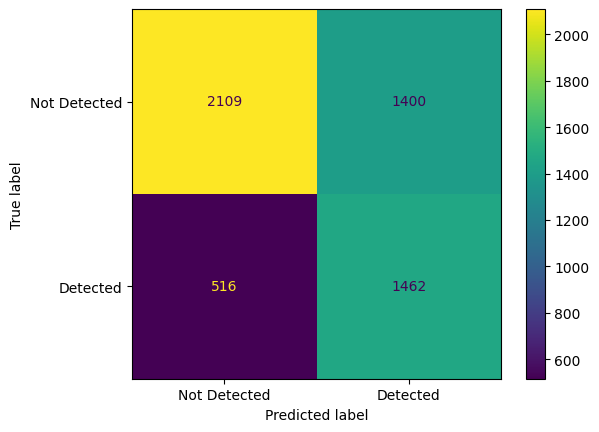

In [11]:
ConfusionMatrixDisplay.from_predictions(df_predicted_observed["Observed"], df_predicted_observed["Aggregated_Score"],
                                        display_labels=["Not Detected", "Detected"],)

## Detectability from Relative fragment ion intensities

In [ ]:
df_all_charged_reporters = df_all_sequences.copy()

pH = 7
internal_standard = "ARKH"
internal_standard_charge = int(charge(internal_standard, pH=pH))
internal_standard_fragment = f"y{len(internal_standard)}+{internal_standard_charge}"
base_charge_state = internal_standard_charge+1


df_all_charged_reporters["Sequence with internal standard"] = df_all_charged_reporters.apply(lambda x: f"{x['Sequence']}{internal_standard}", axis=1)
df_all_charged_reporters["Charge"] = df_all_charged_reporters["Sequence with internal standard"].apply(lambda x: int(max(charge(x, pH=pH), base_charge_state)))
df_all_charged_reporters = filter_model_sequences(df_all_charged_reporters, column="Sequence with internal standard", min_length=7, max_length=30)
df_all_charged_reporters = df_all_charged_reporters[df_all_charged_reporters["Charge"] <= 6]
df_all_charged_reporters.head()

,Accession,Sequence,Observed,Sequence with internal standard,Charge
0,Q8KHU9,QNQILGGSVISNGSTGIVGDLR,True,QNQILGGSVISNGSTGIVGDLRARKH,3
5,Q8KHU9,DLIGTLLIEAGSSGSIIQPR,True,DLIGTLLIEAGSSGSIIQPRARKH,3
6,P01868,NSGSLSSGVHTFPAVLQSDLY,True,NSGSLSSGVHTFPAVLQSDLYARKH,3
7,Q7B8V4,FGFEESLEVDTNPLLGAGK,True,FGFEESLEVDTNPLLGAGKARKH,3
8,Q71JV0,NIYETEIEGNNAIGNDIK,True,NIYETEIEGNNAIGNDIKARKH,3


Text(0.5, 1.0, "Distribution of Charge States for Peptides\nwith Internal Standard 'ARKH'")

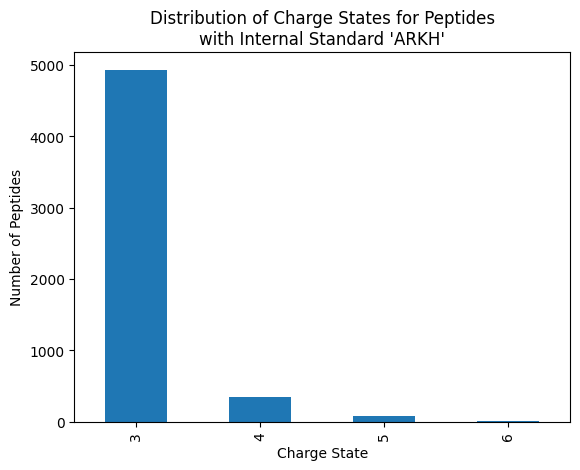

In [21]:
df_all_charged_reporters.Charge.value_counts().sort_index().plot.bar()
plt.xlabel("Charge State")
plt.ylabel("Number of Peptides")
plt.title(f"Distribution of Charge States for Peptides\nwith Internal Standard '{internal_standard}'")

In [35]:
model_inputs = pd.DataFrame()
model_inputs["peptide_sequences"] = df_all_charged_reporters["Sequence with internal standard"].to_numpy()
model_inputs["precursor_charges"] = df_all_charged_reporters["Charge"].to_numpy()
model_inputs["collision_energies"] = [30] * model_inputs.shape[0] # Fixed CE for now


model = Koina("Prosit_2020_intensity_HCD", "koina.wilhelmlab.org:443")
predictions = model.predict(model_inputs, debug=True, min_intensity=1e-6)
predictions.annotation = predictions.annotation.apply(lambda x: x.decode("utf-8"))

Prosit_2020_intensity_HCD::   0%|          | 0/6 [00:00<?, ?it/s]

In [36]:
print(predictions.shape)
predictions.head()

(184990, 6)


,peptide_sequences,precursor_charges,collision_energies,intensities,mz,annotation
0,QNQILGGSVISNGSTGIVGDLRARKH,3,30,0.187580,156.076752,y1+1
0,QNQILGGSVISNGSTGIVGDLRARKH,3,30,0.002981,78.542015,y1+2
0,QNQILGGSVISNGSTGIVGDLRARKH,3,30,0.004325,129.065857,b1+1
0,QNQILGGSVISNGSTGIVGDLRARKH,3,30,0.008912,284.171722,y2+1
0,QNQILGGSVISNGSTGIVGDLRARKH,3,30,0.287160,243.108780,b2+1


In [37]:
annotation_df = pd.DataFrame()
annotation_df["peptide_sequences"] = predictions["peptide_sequences"]
annotation_df["peptide_fragment"] = predictions.apply(lambda x: f"b{len(x.peptide_sequences) - len(internal_standard)}+{x.precursor_charges-internal_standard_charge}", axis=1)
annotation_df.drop_duplicates(inplace=True)
annotation_df

,peptide_sequences,peptide_fragment
0,QNQILGGSVISNGSTGIVGDLRARKH,b22+1
1,DLIGTLLIEAGSSGSIIQPRARKH,b20+1
2,NSGSLSSGVHTFPAVLQSDLYARKH,b21+1
3,FGFEESLEVDTNPLLGAGKARKH,b19+1
4,NIYETEIEGNNAIGNDIKARKH,b18+1
...,...,...
5366,LHNHHTEKARKH,b8+1
5367,NHHTEKSLARKH,b8+1
5368,HHTEKSLARKH,b7+1
5369,HNHHTEKARKH,b7+1


In [38]:
predictions_filtered = predictions[predictions[["peptide_sequences", "annotation"]].apply(tuple, axis=1).isin(annotation_df[["peptide_sequences", "peptide_fragment"]].apply(tuple, axis=1))]
predictions_filtered.shape, predictions.shape

((783, 6), (184990, 6))

In [39]:
predictions_filtered

,peptide_sequences,precursor_charges,collision_energies,intensities,mz,annotation
126,SNLGNIHASNNIARKH,3,30,0.004866,1235.612671,b12+1
265,SPILDLNKVVARKH,3,30,0.000342,1079.645874,b10+1
293,NFNNKDTSNIARKH,3,30,0.009233,1148.533081,b10+1
337,YNTYEKYELIARKH,3,30,0.004630,1317.636108,b10+1
350,SIEYSKDIGLVARKH,3,30,0.003252,1205.641235,b11+1
...,...,...,...,...,...,...
5290,RPKAPQVYARKH,4,30,0.019148,470.771790,b8+2
5291,RPKAPQVYTARKH,4,30,0.010653,521.295654,b9+2
5292,RPKAPQVYTIARKH,4,30,0.010252,577.837646,b10+2
5296,RPKAPQVYTIPPPKARKH,5,30,0.000219,525.311951,b14+3


In [ ]:
predictions